## Import PuLP package

In [66]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
# pulp.pulpTestAll()

## Define Constant

学校のクラス編成問題

- students.csv          :生徒の情報
- student_pairs.csv     :同一クラスに割り当てない生徒のペア
- クラスは8クラスA~Hまでとする

In [68]:
s_df = pd.read_csv('students.csv')
s_pair_df = pd.read_csv('student_pairs.csv')

In [69]:
s_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [70]:
s_df.describe()

,student_id,gender,leader_flag,support_flag,score
count,318.000000,318.000000,318.000000,318.000000,318.000000
mean,159.500000,0.496855,0.053459,0.012579,303.644654
std,91.942917,0.500778,0.225302,0.111622,65.179995
min,1.000000,0.000000,0.000000,0.000000,88.000000
25%,80.250000,0.000000,0.000000,0.000000,261.000000
50%,159.500000,0.000000,0.000000,0.000000,310.000000
75%,238.750000,1.000000,0.000000,0.000000,350.000000
max,318.000000,1.000000,1.000000,1.000000,485.000000


In [71]:
#生徒のリスト
S = s_df['student_id'].to_list()
#クラスのリスト
C = [ 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

## Create Variable

生徒sをクラスcに割り当てる場合に1, そうでない場合に0とする
(s, c) タプルのリスト

In [72]:
SC = [(s,c) for s in S for c in C]

In [73]:
# 0-1整数計画問題の場合 binary
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

In [74]:
x[1, 'A']

x_(1,_'A')

In [75]:
# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]
# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

In [76]:
# 学力のリスト
score = {row.student_id: row.score for row in s_df.itertuples()}
score_mean = s_df.score.mean()

## Create Model

- `LpProblem('name', sense=LpMinimize or LpMaximize)

In [77]:
prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMinimize)

## Create Constraint

In [78]:
# (1) 各生徒とは1つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

In [79]:
# (2) 各クラスの生徒の人数は39人以上、40人以下とする
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

In [80]:
# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

In [81]:
# (4) 各クラスの平均点は全学年平均点の±10とする
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

- 初期クラス編成のデータを作成

In [82]:
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first')
class_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x: x%8).map(class_dict)
s_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D


In [83]:
init_flag = {(s,c): 0 for s in S for c in C}
for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

In [84]:
init_flag

{(1, 'A'): 0,
 (1, 'B'): 0,
 (1, 'C'): 0,
 (1, 'D'): 0,
 (1, 'E'): 0,
 (1, 'F'): 1,
 (1, 'G'): 0,
 (1, 'H'): 0,
 (2, 'A'): 0,
 (2, 'B'): 0,
 (2, 'C'): 0,
 (2, 'D'): 0,
 (2, 'E'): 0,
 (2, 'F'): 0,
 (2, 'G'): 1,
 (2, 'H'): 0,
 (3, 'A'): 0,
 (3, 'B'): 0,
 (3, 'C'): 0,
 (3, 'D'): 0,
 (3, 'E'): 0,
 (3, 'F'): 0,
 (3, 'G'): 0,
 (3, 'H'): 1,
 (4, 'A'): 0,
 (4, 'B'): 0,
 (4, 'C'): 0,
 (4, 'D'): 0,
 (4, 'E'): 1,
 (4, 'F'): 0,
 (4, 'G'): 0,
 (4, 'H'): 0,
 (5, 'A'): 0,
 (5, 'B'): 0,
 (5, 'C'): 0,
 (5, 'D'): 1,
 (5, 'E'): 0,
 (5, 'F'): 0,
 (5, 'G'): 0,
 (5, 'H'): 0,
 (6, 'A'): 0,
 (6, 'B'): 0,
 (6, 'C'): 0,
 (6, 'D'): 0,
 (6, 'E'): 0,
 (6, 'F'): 1,
 (6, 'G'): 0,
 (6, 'H'): 0,
 (7, 'A'): 0,
 (7, 'B'): 0,
 (7, 'C'): 0,
 (7, 'D'): 0,
 (7, 'E'): 0,
 (7, 'F'): 0,
 (7, 'G'): 1,
 (7, 'H'): 0,
 (8, 'A'): 0,
 (8, 'B'): 0,
 (8, 'C'): 0,
 (8, 'D'): 0,
 (8, 'E'): 1,
 (8, 'F'): 0,
 (8, 'G'): 0,
 (8, 'H'): 0,
 (9, 'A'): 0,
 (9, 'B'): 0,
 (9, 'C'): 0,
 (9, 'D'): 0,
 (9, 'E'): 0,
 (9, 'F'): 0,
 (9, 'G'): 1,
 (9, '

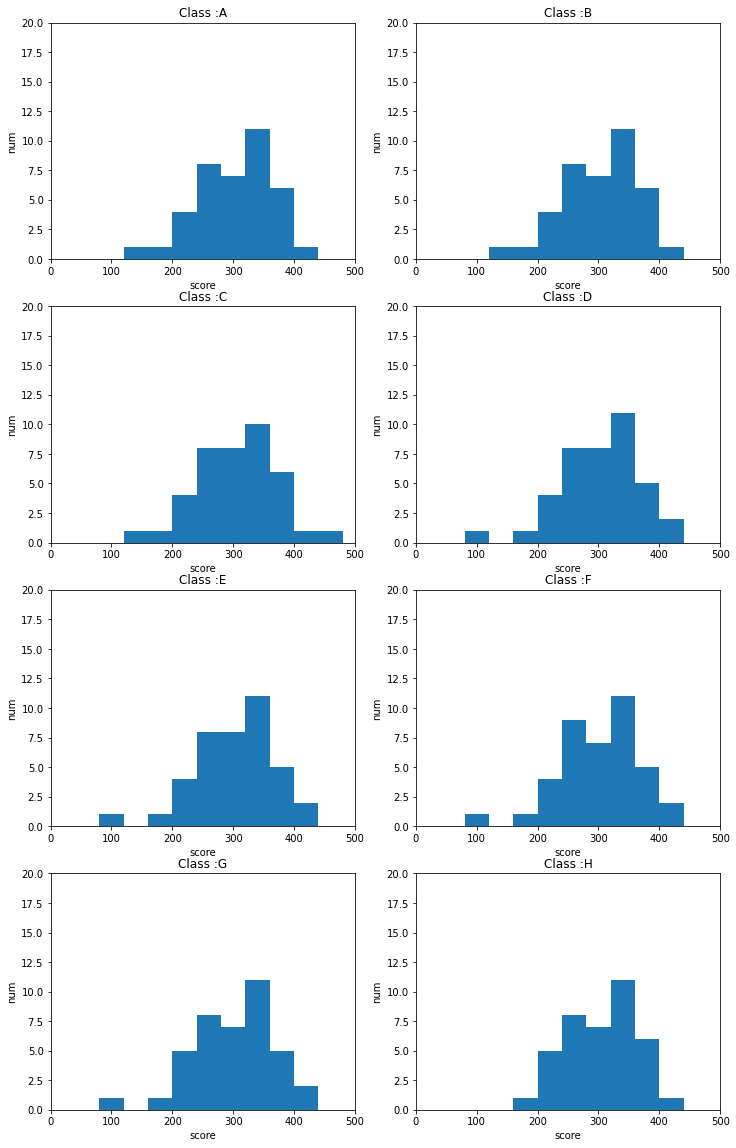

In [85]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = s_df[s_df['init_assigned_class']==c]
    ax = fig.add_subplot(4
                        , 2
                        , i+1
                        , xlabel='score'
                        , ylabel='num'
                        , xlim=(0,500)
                        , ylim=(0,20)
                        , title=f'Class :{c}'
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))

## Create Target function

In [86]:
prob += pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])

## Exec Solver

- Default solver is CBC. You can use GLPK if installed.

In [87]:
status = prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/norihito/workspace/optimization-problems/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/809651158f0b4a77806ca7314e0216dd-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/809651158f0b4a77806ca7314e0216dd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 371 COLUMNS
At line 21042 RHS
At line 21409 BOUNDS
At line 23954 ENDATA
Problem MODEL has 366 rows, 2544 columns and 15264 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.02 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 358 rows, 2544 columns (2544 integer (2544 of which binary)) and 12720 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.53211e-14
Cbc0038I Solution found of 0
Cbc0038I Before min

## Check status

- You can check the status by `LpStatus` which shows 
    {0: 'Not Solved', 1: 'Optimal', -1:'Infeasible', -2: 'Unbounded', -3: 'Undefined'}

In [88]:
pulp.LpStatus

{0: 'Not Solved',
 1: 'Optimal',
 -1: 'Infeasible',
 -2: 'Unbounded',
 -3: 'Undefined'}

In [89]:
pulp.LpStatus[prob.status]
# pulp.LpStatus[status]

'Optimal'

## Result 

In [90]:
C2Ss = {} 
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value() == 1]

In [91]:
for c ,Ss in C2Ss.items():
    print('Class: ', c)
    print('Num: ', len(Ss))
    print('Student: ', Ss)
    print()

Class:  A
Num:  40
Student:  [2, 16, 17, 19, 21, 26, 27, 75, 76, 78, 85, 97, 100, 105, 121, 129, 139, 149, 161, 165, 169, 189, 196, 202, 213, 215, 240, 243, 246, 252, 253, 254, 256, 264, 267, 270, 275, 278, 279, 300]

Class:  B
Num:  40
Student:  [1, 11, 33, 36, 37, 40, 54, 55, 61, 63, 65, 73, 82, 101, 106, 118, 143, 145, 148, 150, 153, 157, 163, 171, 176, 187, 194, 207, 208, 210, 211, 220, 247, 248, 276, 286, 287, 297, 308, 313]

Class:  C
Num:  39
Student:  [3, 8, 23, 30, 32, 41, 48, 52, 56, 67, 69, 77, 83, 102, 103, 122, 131, 134, 138, 154, 155, 162, 178, 184, 209, 214, 224, 228, 235, 236, 242, 255, 265, 269, 274, 288, 289, 294, 316]

Class:  D
Num:  39
Student:  [14, 20, 22, 35, 43, 45, 49, 62, 70, 71, 87, 88, 89, 96, 99, 107, 112, 113, 119, 132, 133, 146, 166, 183, 191, 192, 197, 201, 212, 216, 234, 245, 262, 273, 280, 283, 302, 303, 309]

Class:  E
Num:  40
Student:  [6, 9, 15, 31, 39, 42, 46, 53, 60, 64, 108, 110, 111, 124, 141, 142, 144, 151, 156, 159, 160, 170, 173, 186, 204, 

## Verification

In [92]:
result_df = s_df.copy()
result_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D


In [93]:
S2C = {s:c for s in S for c in C if x[s,c].value() == 1}

In [94]:
result_df['assigned_class'] = result_df['student_id'].map(S2C)
result_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,B
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,C
3,4,0,0,0,301,172.0,E,H
4,5,1,0,0,317,147.0,D,G


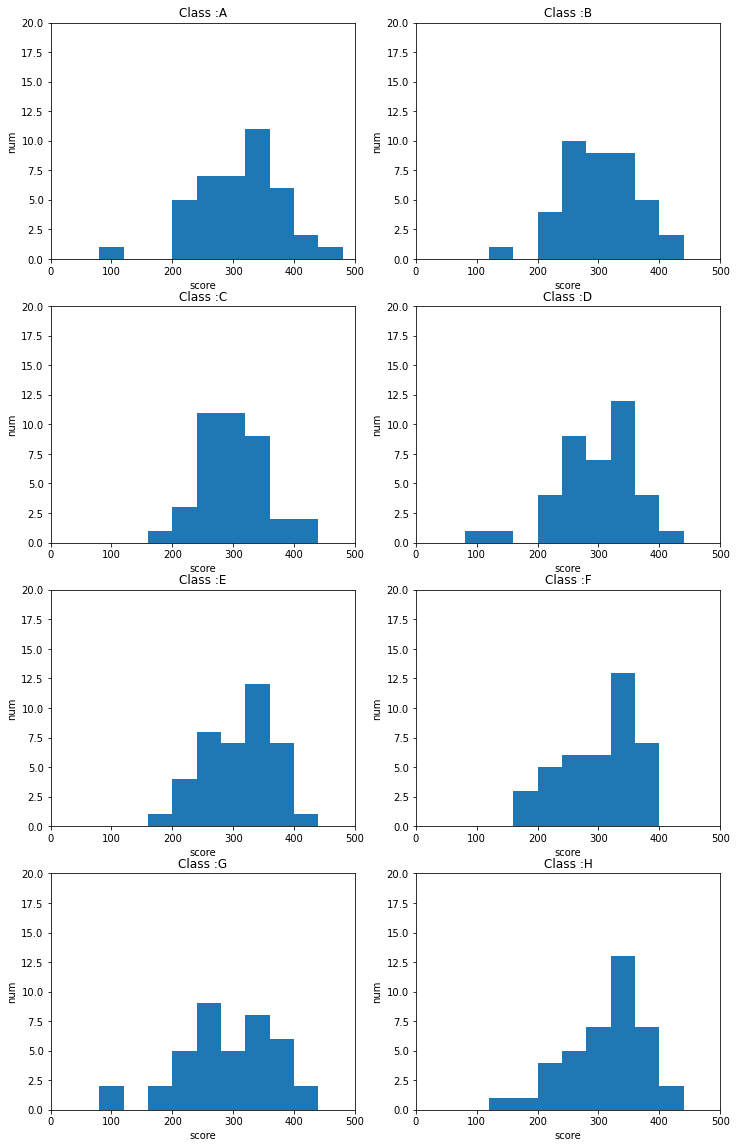

In [95]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = result_df[result_df['assigned_class']==c]
    ax = fig.add_subplot(4
                        , 2
                        , i+1
                        , xlabel='score'
                        , ylabel='num'
                        , xlim=(0,500)
                        , ylim=(0,20)
                        , title=f'Class :{c}'
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))